### Imports

In [1]:
import rawpy
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from PIL import Image
from colour import (read_LUT,
                    RGB_to_XYZ,
                    XYZ_to_ProLab,
                    ProLab_to_XYZ,
                    XYZ_to_RGB)

## Raw Converter

### Variables

In [2]:
# variables
IMAGE_NAME = "WYQ_9816"
INPUT_PATH = "../samples/" + IMAGE_NAME + ".nef"
NOISE_SAMPLE_PATH = "../samples/kodak-portra.npy"

BR_COEF: float = 1.2  # blur radius coefficient
BS_COEF: float = 1.  # blur spread coefficient
HALATION: float = 1.

### Import raw files

In [3]:
def read_raw(path: str) -> np.array:
    """
    Takes in raw image file and returns numpy array
    :param path:  
    :return: (np.array, shape)
    """
    with rawpy.imread(path) as raw:
        img = raw.postprocess(  # returns numpy array
            output_color=rawpy.ColorSpace(1),  # covert to srgb
            half_size=True,
            use_camera_wb=True,  # user_wb=(1,1,1,1),
            output_bps=16,
            no_auto_bright=True,
            no_auto_scale=False,
            gamma=(1, 1),
            chromatic_aberration=(1, 1),
        )
        img = img.astype(np.float32)
        return img, img.shape


In [4]:
image, image_shape = read_raw(INPUT_PATH)
image_shape

(1422, 2142, 3)

### Preprocessing

In [5]:
def show_img(img: np.array):
    img = (img // 257).astype(np.uint8)
    Image.fromarray(img).show()


# TO DO: make notebook inline preview 
show_img(image)

In [6]:
# normalize into the range between 200 and 100_000 
# which equals to 2.7D (log10) == 9ev (log2)
def normalize_by_18pct_grey(img: np.array) -> np.array:
    return img * 50_000 / np.average(img) + 200

In [7]:
# clipped areas is everything that >= 65535
image_norm = normalize_by_18pct_grey(image)
show_img(image_norm)

In [8]:
def gen_blur_matrix(n: int = 10, k: int = 50) -> np.array:
    """
    Create a blur matrix based on the
    hyperbolic decay function: https://habr.com/ru/articles/432622/
    :param n:  blur radius 
    :param k: spread coefficient
    :return: 2-dimensional matrix
    """
    x = np.fabs(  # create a linear space from -1 to 1 with 2n+1 steps
        np.linspace(-n, n, n * 2 + 1) / n
    )
    kernel_1d = (  # apply the hyperbolic decay function
            (((x - 1) ** 2) * (x * k + k + 1))
            /
            ((k + 1) * (k * x + 1))
    )
    # create an outer product normalized matrix
    kernel_2d = np.outer(kernel_1d.T, kernel_1d.T)
    kernel_2d /= np.sum(kernel_2d)
    return kernel_2d

In [9]:
# 2_000 is an arbitrary number chosen relying on perceptual feeling
_BLUR_CONSTANT = 2_000 / np.max(image_shape)  # normalize with respect to the biggest side

blur_params = [
    {
        "channel": "red",
        "channel_idx": 0,
        "radius": int(12 * BR_COEF * HALATION * _BLUR_CONSTANT),
        "spread": int(25 * BS_COEF),
    },
    {
        "channel": "green",
        "channel_idx": 1,
        "radius": int(5 * BR_COEF * _BLUR_CONSTANT),
        "spread": int(25 * BS_COEF),
    },
    {
        "channel": "blue",
        "channel_idx": 2,
        "radius": int(3 * BR_COEF * _BLUR_CONSTANT),
        "spread": int(25 * BS_COEF),
    }
]


def blur_image(img: np.array, params: list[dict]) -> np.array:
    """
    Apply blur matrix convolution to each layer using individual blur parameters.
    :param img: np.array
    :param params: list of dictionaries
    :return: np.array
    """
    return np.dstack([
        signal.convolve2d(
            in1=img[:, :, p["channel_idx"]],
            in2=gen_blur_matrix(p["radius"], p["spread"]),
            mode="same"
        ) for p in params
    ])

In [10]:
image_blur = blur_image(image_norm, blur_params)
show_img(image_blur)

In [11]:
# convert blurred image into human perception range
def log_convert(img: np.array) -> np.array:
    img_log = np.log10(img)
    return (
            (img_log - 2.3)
            /
            (np.max(img_log) - 2.3)
    )

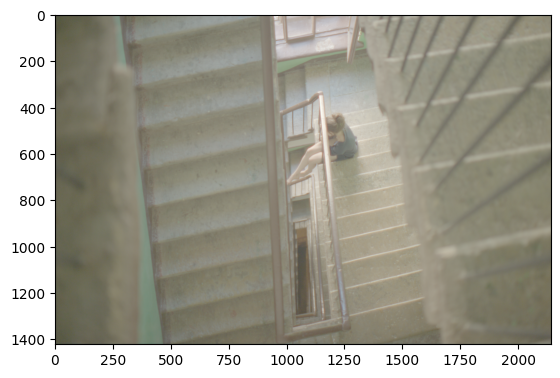

In [12]:
# we are done with preprocessing and ready to work with colors
image_norm = log_convert(image_blur)
plt.imshow(image_norm);

## Do Film

### Variables

In [13]:
# film variables
FILM_CURVE = read_LUT("../film/film_curve_portra_400.spi1d")
FILM_COLOUR = read_LUT("../film/Portra_400.cube")
NOISE_SAMPLE = Image.open("../film/grain_portra400.tif")
GRAIN_CURVE = read_LUT("../film/Grain_curve.spi1d")

# lab channels balance
END_A_PLUS: float = 3.
END_A_MINUS: float = 1.5
END_B_PLUS: float = 2.
END_B_MINUS: float = 4.

# white balance correction coefficients
WB_RED: float = 0.
WB_GREEN: float = 0.
WB_BLUE: float = 0.

# saturation adjustment
SATURATION: float = .5

# film adjustments
SCENE_CONTRAST: int = 6
EXPOSURE_SHIFT: int = -3

# final print settings
PRINT_EXPOSURE: float = -0.1
PRINT_CONTRAST: float = 4

### WB correction

In [14]:
def apply_wb_correction(img: np.array, r: float, g: float, b: float) -> np.array:
    img[:, :, 0] += r
    img[:, :, 1] += g
    img[:, :, 2] += b
    return img

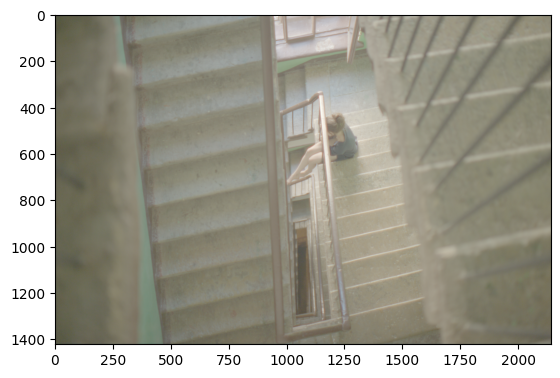

In [15]:
image_wb = apply_wb_correction(
    image_norm, WB_RED, WB_GREEN, WB_BLUE
)

plt.imshow(image_wb);

### Film LUT

In [16]:
def apply_film_lut(img: np.array, cont_scene: int, exp_shift: float) -> np.array:
    # dynamic range compression, total 9ev
    app_cont_scene = img / 9 * cont_scene
    # normalize after adapting for dynamic range
    auto_grey = app_cont_scene + (0.29 - np.mean(app_cont_scene))
    # over/under exposure emulation, shift exposure before applying LUT
    colored = FILM_COLOUR.apply((auto_grey + exp_shift / 9))
    # normalize again to account for film error, shift exposure again
    normalized = colored + (0.4 - np.mean(colored)) + exp_shift / 9
    # apply contrast curve
    curved = FILM_CURVE.apply(normalized)
    # normalize the result 
    result = (curved - np.mean(curved)) / cont_scene * 9 + 0.5

    return result

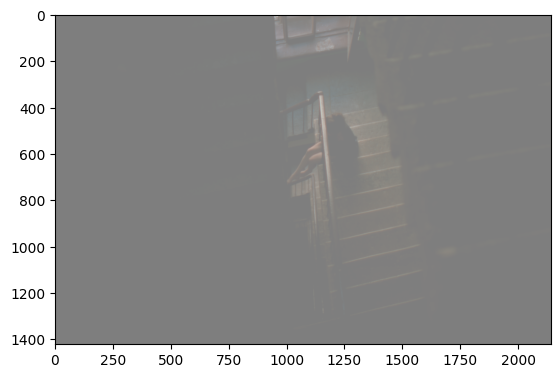

In [17]:
image_film = apply_film_lut(
    image_wb, SCENE_CONTRAST, EXPOSURE_SHIFT
)

plt.imshow(image_film);

### Contrast

In [18]:
def apply_cont_curve(img: np.array, print_cont: float, print_exp: float) -> np.array:
    return (1 / (1 + np.power(
        10 ** print_cont,
        2 * (-img - print_exp + 0.5))
                 ))

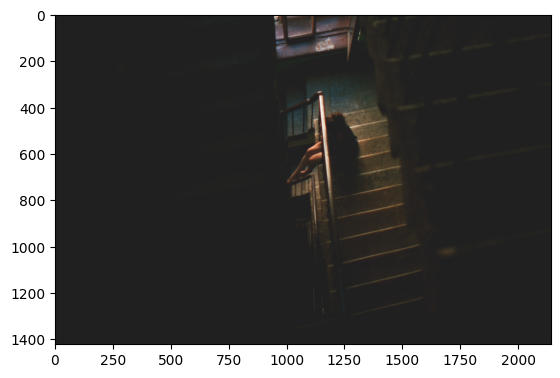

In [19]:
image_cont = apply_cont_curve(image_film, PRINT_CONTRAST, PRINT_EXPOSURE)
plt.imshow(image_cont);

### ProLab

In [20]:
def rgb_to_prolab(img: np.array, **kwargs) -> np.array:
    xyz = RGB_to_XYZ(img, "sRgb", chromatic_adaptation_transform=None,
                     illuminant=None, **kwargs)
    prolab = XYZ_to_ProLab(xyz)
    return prolab

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


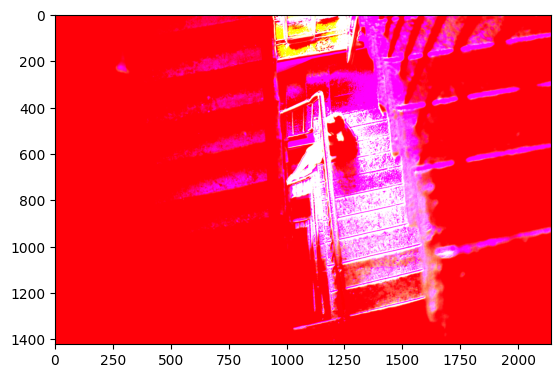

In [21]:
image_prolab = rgb_to_prolab(image_cont)
plt.imshow(image_prolab);

### Saturation

In [22]:
def apply_saturation(img: np.array, channel: int, end: float, mask_less_zero: bool):
    if mask_less_zero:
        mask = img[:, :, channel] < 0
    else:
        mask = img[:, :, channel] >= 0

    array = img[:, :, channel][mask]
    img[:, :, channel][mask] = ((2 / (1 + np.power((16 ** end), -array / 100)) - 1) * 100 / end)


params = [
    (1, END_A_MINUS, True),
    (1, END_A_PLUS, False),
    (2, END_B_MINUS, True),
    (2, END_B_MINUS, False)
]

image_prolab[:, :, 1] *= SATURATION
image_prolab[:, :, 2] *= SATURATION

for channel, end, less_zero in params:
    apply_saturation(image_prolab, channel, end, less_zero)

### Back to sRgb

In [23]:
def prolab_to_rgb(img: np.array, **kwargs) -> np.array:
    xyz = ProLab_to_XYZ(img)
    rgb = XYZ_to_RGB(xyz, "sRGB", chromatic_adaptation_transform=None,
                     illuminant=None, **kwargs)
    return rgb

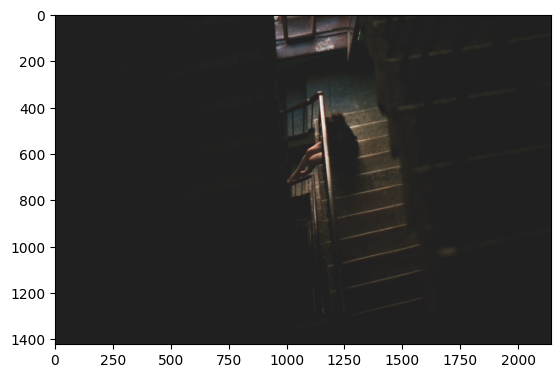

In [24]:
image_rgb = prolab_to_rgb(image_prolab)
plt.imshow(image_rgb);

### Grain

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


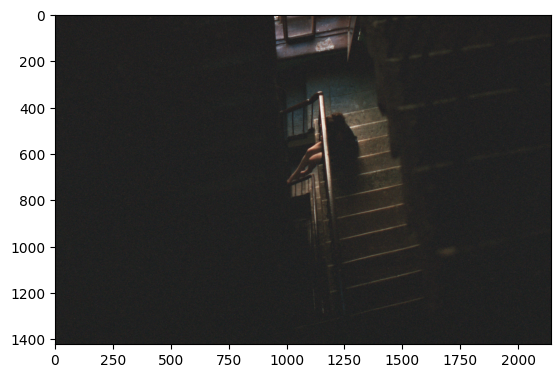

In [25]:
def apply_grain(img: np.array, grain_sample, amplify: float, amplify_mask: float) -> np.array:
    if img.shape[0] > img.shape[1]:
        grain_sample = grain_sample.transpose(method=Image.Transpose.ROTATE_90)

    grain_crop = grain_sample.crop((0, 0, img.shape[1], img.shape[0]))
    grain = np.asarray(grain_crop, dtype=np.float32) / 255.
    grain -= np.mean(grain)

    grain_mask = GRAIN_CURVE.apply(img)
    grain = (grain * amplify * (grain_mask ** amplify_mask)) + 1
    img *= grain

    return img


image_grain = apply_grain(
    image_rgb, NOISE_SAMPLE, 0.15, 6.
)
plt.imshow(image_grain);

In [26]:
white = 254
to_out = np.around(image_grain * white)
to_out[np.where(to_out <= 0)] = 0
to_out[np.where(to_out >= 255)] = 255
out = to_out.astype(np.uint8)
pill = Image.fromarray(out)
pill.show()